<a href="https://colab.research.google.com/github/satyakipal99/asl_alphabet_model/blob/main/asl_alphabet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle dataset importing

In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                           1MB  2024-04-10 09:48:38           6853        136  1.0              
sujithmandala/second-hand-car-price-prediction                   Second Hand Car Price Prediction                      2KB  2024-04-24 12:09:30            856         24  1.0              
aniketmahajan1104/indian-cities-electricity-consumption-2017-19  Indian Cities Electricity Consumption 2017-19         2KB  2024-04-24 09:34:25            567         23  1.0              
mexwell/heart-disease-dataset                          

In [9]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:41<00:00, 26.0MB/s]
100% 1.03G/1.03G [00:41<00:00, 26.5MB/s]


In [11]:
!mkdir kaggle

In [15]:
!ls

asl-alphabet.zip  input  kaggle  kaggle.json  sample_data


In [16]:
!unzip asl-alphabet.zip -d kaggle

Streaming output truncated to the last 5000 lines.
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: kaggle/asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: kaggle/asl_alph

## Importing libraries

In [21]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [18]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Dataset loading and pre-processing

In [19]:
# Labels
TRAIN_PATH = "/content/kaggle/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [24]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

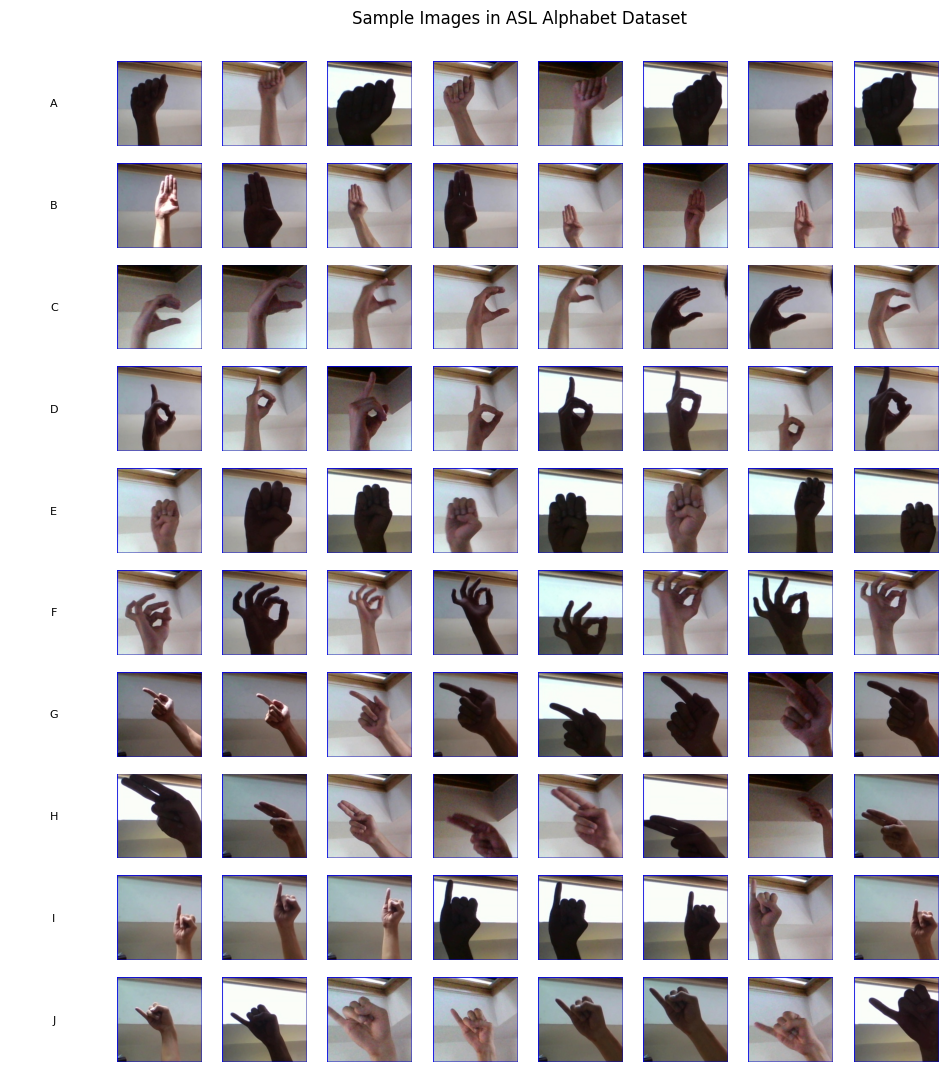

In [25]:
sample_images(labels[:10])

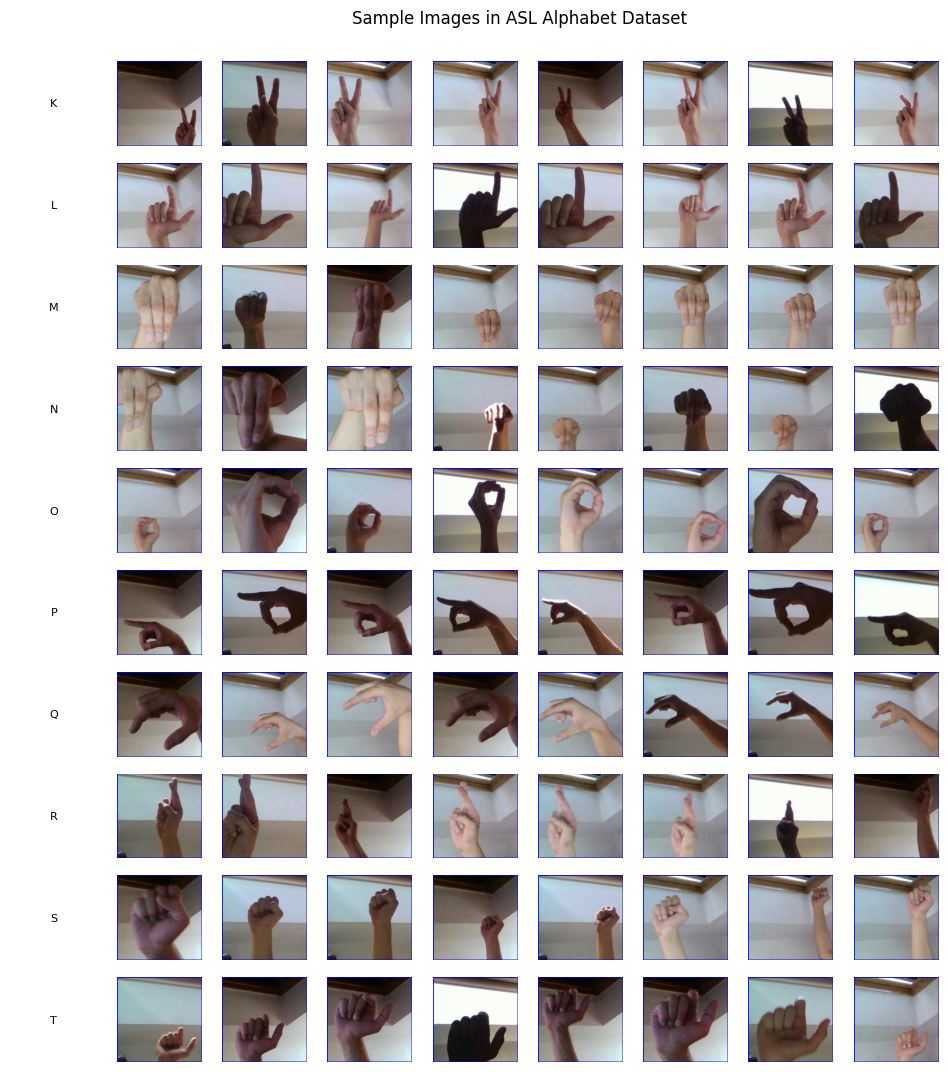

In [26]:
sample_images(labels[10:20])

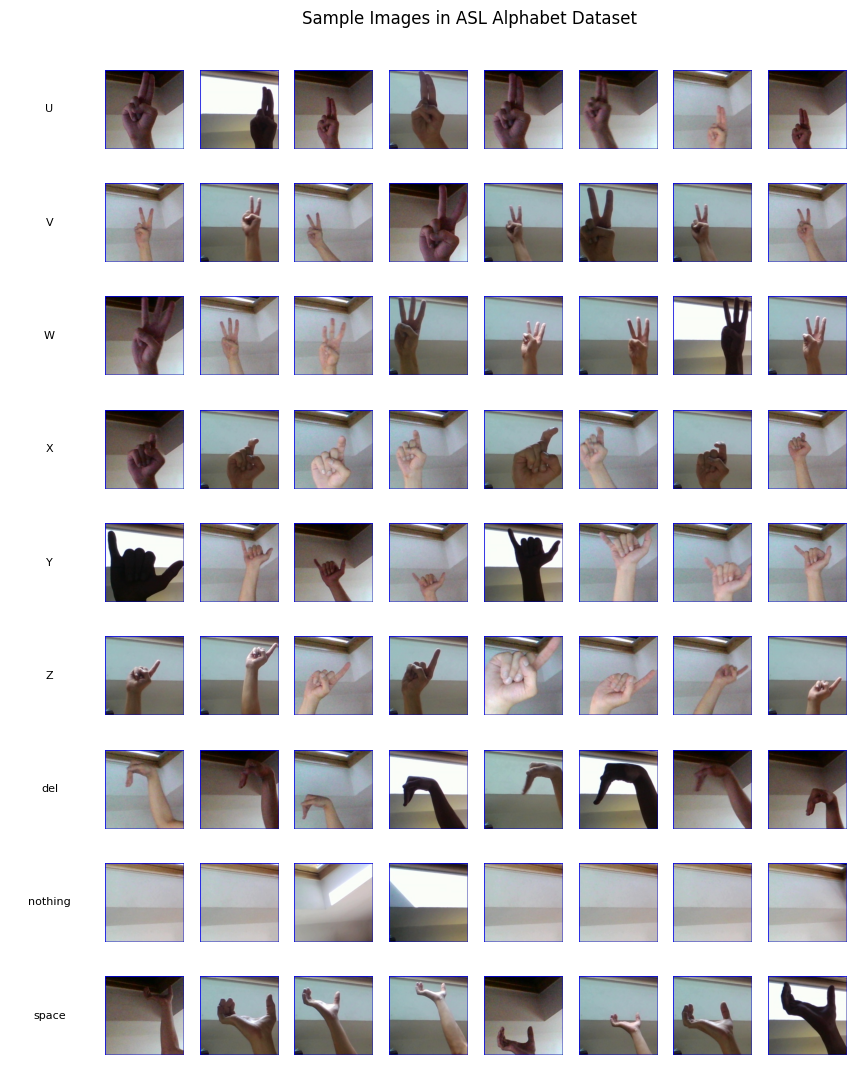

In [27]:
sample_images(labels[20:])

In [28]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 20
    num_classes = 29
    img_channels = 3

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [29]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

image_path  label
0      /content/kaggle/asl_alphabet_train/asl_alphabe...      A
1      /content/kaggle/asl_alphabet_train/asl_alphabe...      A
2      /content/kaggle/asl_alphabet_train/asl_alphabe...      A
3      /content/kaggle/asl_alphabet_train/asl_alphabe...      A
4      /content/kaggle/asl_alphabet_train/asl_alphabe...      A
...                                                  ...    ...
86995  /content/kaggle/asl_alphabet_train/asl_alphabe...  space
86996  /content/kaggle/asl_alphabet_train/asl_alphabe...  space
86997  /content/kaggle/asl_alphabet_train/asl_alphabe...  space
86998  /content/kaggle/asl_alphabet_train/asl_alphabe...  space
86999  /content/kaggle/asl_alphabet_train/asl_alphabe...  space

[87000 rows x 2 columns]

In [30]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=0.15,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

image_path    label
51901  /content/kaggle/asl_alphabet_train/asl_alphabe...        R
51887  /content/kaggle/asl_alphabet_train/asl_alphabe...        R
5050   /content/kaggle/asl_alphabet_train/asl_alphabe...        B
29446  /content/kaggle/asl_alphabet_train/asl_alphabe...        J
58405  /content/kaggle/asl_alphabet_train/asl_alphabe...        T
...                                                  ...      ...
47111  /content/kaggle/asl_alphabet_train/asl_alphabe...        P
83611  /content/kaggle/asl_alphabet_train/asl_alphabe...  nothing
67329  /content/kaggle/asl_alphabet_train/asl_alphabe...        W
85296  /content/kaggle/asl_alphabet_train/asl_alphabe...    space
60158  /content/kaggle/asl_alphabet_train/asl_alphabe...        U

[58103 rows x 2 columns]

image_path label
24961  /content/kaggle/asl_alphabet_train/asl_alphabe...     I
71053  /content/kaggle/asl_alphabet_train/asl_alphabe...     X
73637  /content/kaggle/asl_alphabet_train/asl_alphabe...     Y
72875  /content/kaggle/asl_alphabet_train/asl_alphabe...     Y
40669  /content/kaggle/asl_alphabet_train/asl_alphabe...     N
...                                                  ...   ...
16474  /content/kaggle/asl_alphabet_train/asl_alphabe...     F
62741  /content/kaggle/asl_alphabet_train/asl_alphabe...     U
32281  /content/kaggle/asl_alphabet_train/asl_alphabe...     K
20451  /content/kaggle/asl_alphabet_train/asl_alphabe...     G
2962   /content/kaggle/asl_alphabet_train/asl_alphabe...     A

[15847 rows x 2 columns]

image_path  label
73327  /content/kaggle/asl_alphabet_train/asl_alphabe...      Y
85482  /content/kaggle/asl_alphabet_train/asl_alphabe...  space
65607  /content/kaggle/asl_alphabet_train/asl_alphabe...      V
53903  /content/kaggle/asl_alphabet_train/asl_alphabe...      R
64425  /content/kaggle/asl_alphabet_train/asl_alphabe...      V
...                                                  ...    ...
40578  /content/kaggle/asl_alphabet_train/asl_alphabe...      N
28949  /content/kaggle/asl_alphabet_train/asl_alphabe...      J
42094  /content/kaggle/asl_alphabet_train/asl_alphabe...      O
5425   /content/kaggle/asl_alphabet_train/asl_alphabe...      B
49381  /content/kaggle/asl_alphabet_train/asl_alphabe...      Q

[13050 rows x 2 columns]

In [31]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )

    return train_generator, validation_generator, test_generator
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


## Model selection and training

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

None

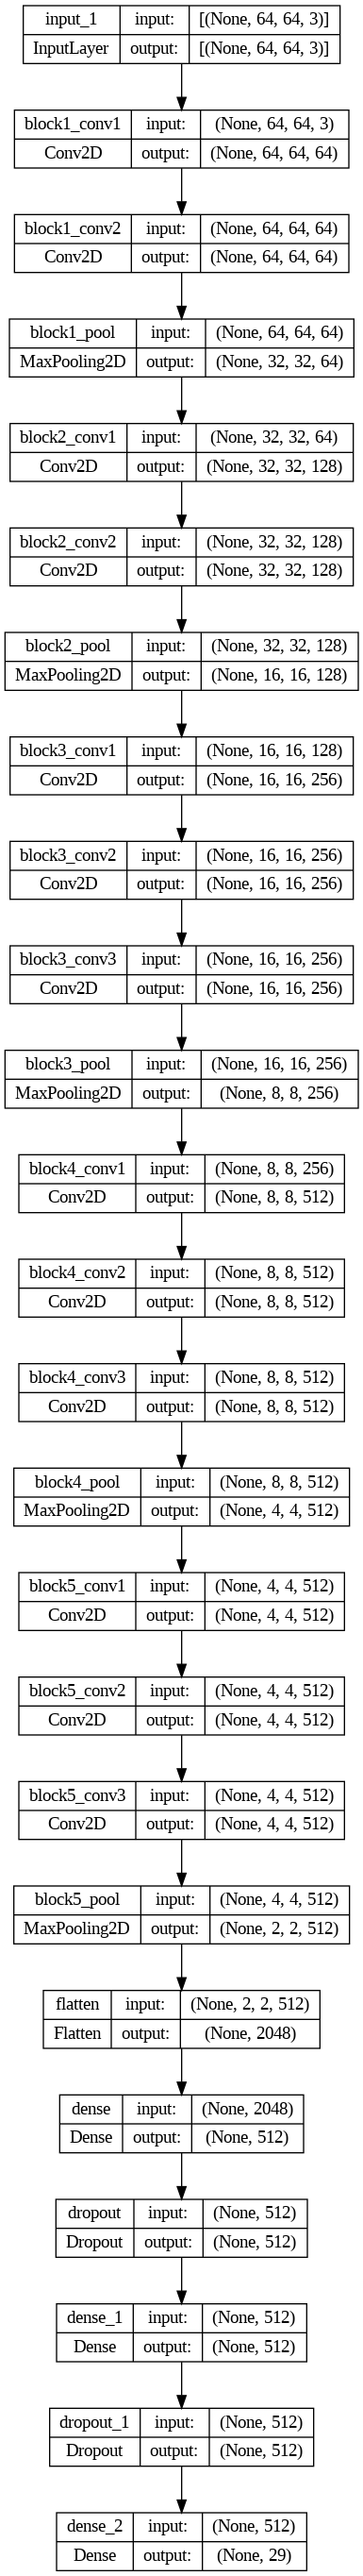

In [32]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

In [33]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [34]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/20
907/907 [==============================] - 83s 84ms/step - loss: 1.1195 - accuracy: 0.6479 - val_loss: 0.2578 - val_accuracy: 0.9212
Epoch 2/20
907/907 [==============================] - 72s 79ms/step - loss: 0.4021 - accuracy: 0.8641 - val_loss: 0.1394 - val_accuracy: 0.9536
Epoch 3/20
907/907 [==============================] - 74s 81ms/step - loss: 0.2950 - accuracy: 0.8989 - val_loss: 0.1000 - val_accuracy: 0.9712
Epoch 4/20
907/907 [==============================] - 64s 71ms/step - loss: 0.2476 - accuracy: 0.9157 - val_loss: 0.0612 - val_accuracy: 0.9843
Epoch 5/20
907/907 [==============================] - 64s 71ms/step - loss: 0.2234 - accuracy: 0.9239 - val_loss: 0.0654 - val_accuracy: 0.9805
Epoch 6/20
907/907 [==============================] - 64s 71ms/step - loss: 0.1974 - accuracy: 0.9330 - val_loss: 0.0460 - val_accuracy: 0.9859
Epoch 7/20
907/907 [==============================] - 66s 72ms/step - loss: 0.1844 - accuracy: 0.9354 - val_loss: 0.0449 - val_accuracy:

## Testing and training metrics

In [35]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

13050/13050 [==============================] - 76s 6ms/step - loss: 0.0211 - accuracy: 0.9941
Evaluate Test Accuracy: 99.41%


In [36]:
# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"],
)

# Configuration Plot
class PlotCFG:
    marker_size = 8
    line_size = 2
    train_color = "#76503d"
    valid_color = "#deb392"

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5,
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

## Confusion Matrix

In [38]:
# Confusion Matrix
fine_tuned_model = load_model("/content/asl_vgg16_best_weights.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 55s 4ms/step


In [39]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=labels,
        y=labels,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

## t-SNE Visualization

In [40]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-3].output)
dense_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [41]:
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [43]:
# Extract Features in Dense Layer
def dense_feature_prediction(img_path):
    img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
    label_data = data_test[data_test["label"]==label][:100]
    reduction_data = pd.concat([reduction_data, label_data])

reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

dense_features = reduction_data["image_path"].progress_apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)

image_path  label
0     /content/kaggle/asl_alphabet_train/asl_alphabe...      A
1     /content/kaggle/asl_alphabet_train/asl_alphabe...      A
2     /content/kaggle/asl_alphabet_train/asl_alphabe...      A
3     /content/kaggle/asl_alphabet_train/asl_alphabe...      A
4     /content/kaggle/asl_alphabet_train/asl_alphabe...      A
...                                                 ...    ...
2895  /content/kaggle/asl_alphabet_train/asl_alphabe...  space
2896  /content/kaggle/asl_alphabet_train/asl_alphabe...  space
2897  /content/kaggle/asl_alphabet_train/asl_alphabe...  space
2898  /content/kaggle/asl_alphabet_train/asl_alphabe...  space
2899  /content/kaggle/asl_alphabet_train/asl_alphabe...  space

[2900 rows x 2 columns]

100%|██████████| 2900/2900 [03:53<00:00, 12.43it/s]


In [44]:
# tSNE Dimensional Reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.006s...
[t-SNE] Computed neighbors for 2900 samples in 0.425s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 5.298710
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.421501
[t-SNE] KL divergence after 1000 iterations: 0.602113


image_path  label  tsne_feat_0  \
0     /content/kaggle/asl_alphabet_train/asl_alphabe...      A    -4.369267   
1     /content/kaggle/asl_alphabet_train/asl_alphabe...      A    -1.864772   
2     /content/kaggle/asl_alphabet_train/asl_alphabe...      A    -4.656680   
3     /content/kaggle/asl_alphabet_train/asl_alphabe...      A     0.169954   
4     /content/kaggle/asl_alphabet_train/asl_alphabe...      A     0.573061   
...                                                 ...    ...          ...   
2895  /content/kaggle/asl_alphabet_train/asl_alphabe...  space    16.829569   
2896  /content/kaggle/asl_alphabet_train/asl_alphabe...  space    14.852377   
2897  /content/kaggle/asl_alphabet_train/asl_alphabe...  space    15.761912   
2898  /content/kaggle/asl_alphabet_train/asl_alphabe...  space    16.988327   
2899  /content/kaggle/asl_alphabet_train/asl_alphabe...  space    15.511559   

      tsne_feat_1  
0       16.464380  
1       19.117088  
2       20.881039  
3       18.774517  
4       17.104294  
...           ...  
2895    -8.162224  
2896    -9.644217  
2897    -8.230381  
2898    -6.408393  
2899    -9.496919  

[2900 rows x 4 columns]

In [45]:
# Scatter Plot
list_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000",
               "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
               "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
              ]
fig = px.scatter(
    reduction_data, x="tsne_feat_0", y="tsne_feat_1", color='label', color_discrete_sequence=list_colors
)

fig.update_traces(marker=dict(size=8),)

# Update Axes
fig.update_xaxes(title="", linecolor="Black", zeroline=False, mirror=True)
fig.update_yaxes(title="", linecolor="Black", zeroline=False, mirror=True)

# Update Layout
fig.update_layout(
    title_text="t-SNE Visualization", title_x=0.5,
    width=900, height=900,
    plot_bgcolor='White',
    coloraxis_showscale=False,
)

# Show
fig.show()

## Save Model

In [46]:
model.save('asl_alphabet_model.h5')